**Note:** I've already tested/compared multiple models using the PyCaret on Google Colab (with a Tesla V100 GPU). Please refer to the pycaret.ipynb notebook.

# **Settings**

In [1]:
# Since I'm working in a project folder called "crm-project"
# I'm setting this notebook to that project folder as the working directory 

import os

current_working_dir = os.path.normpath(os.getcwd()).split(os.path.sep)[-1]

if current_working_dir != 'crm_project':
    os.chdir('..')

## Libraries

In [2]:
# Data wrangling & statistics
import numpy as np
import pandas as pd

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go

from yellowbrick.contrib.wrapper import wrap
from yellowbrick.classifier.rocauc import roc_auc
from yellowbrick.classifier import classification_report, confusion_matrix

# Machine Learning
import shap
import pickle
from catboost import CatBoostClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.compose import ColumnTransformer
from feature_engine.outliers import Winsorizer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler

# Custom functions
import src.config as config
from src.utils.metrics import false_positive_rate, false_negative_rate, auc_precision_recall, compute_metrics, prepare_cv_results

# Set transform output as pandas
from sklearn import set_config
set_config(transform_output="pandas")

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## Plot Settings

In [3]:
# Customize your theme, please see:
# https://matplotlib.org/stable/tutorials/introductory/customizing.html

sns.set_theme(
    context='talk',
    style='ticks',
    font_scale=.75,
    palette=['#16a3ae', '#f69f38'],
    rc={        'figure.figsize': (6,4),
        'axes.grid': True,
        'grid.alpha': .3,
        'axes.titlesize': 'large',
        'axes.titleweight': 'bold',
        'axes.titlepad': 30,
        'axes.labelpad': 15
    }
)

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Arial', 'Liberation Sans', 'Bitstream Vera Sans', 'sans-serif']

## Configs

In [4]:
TARGET = config.TARGET
FEATURES = config.FEATURES
MODEL_PARAMS = config.MODEL_PARAMS

## Load datasets

In [5]:
# Load datasets, specifying the customer IDs as index
df_train = pd.read_csv('data/train_set.csv', index_col='mk_CurrentCustomer')
df_test = pd.read_csv('data/test_set.csv', index_col='mk_CurrentCustomer')
df_customer_country = pd.read_csv('data/customer_country.csv', index_col='mk_CurrentCustomer')

# Convert date columns to date specifying the format (it's much faster when specifying it)
df_train['ScoreDate'] = pd.to_datetime(df_train['ScoreDate'], format='%d/%m/%Y %H:%M')

# Merging the datasets
# Note: Since there are no duplicated IDs (see next cells), so it's safe to merge it
df = df_train.join(df_customer_country, how='left')

# Show quantity of rows, columns, and first rows
print(df.shape)
display(df.head())

(55415, 270)


,ScoreDate,days_g10,days_g9,days_g8,days_g7,days_g6,days_g5,days_g4,days_g3,days_g2,...,days_since_last_SE_GI,SE_GI_max_datediff,SE_GI_min_datediff,SE_GI_avg_datediff,SE_GI_std_datediff,days_since_last_SE_GI_wrt_max,days_since_last_SE_GI_wrt_min,days_since_last_SE_GI_wrt_avg,days_since_last_SE_GI_wrt_std,country
mk_CurrentCustomer,,,,,,,,,,,,,,,,,,,,,
10871718,2019-08-29,2,0,2,3,3,3,2,5,4,...,15,-1,-1,-1,-1.0,-1,-1,-1,-1.0,France
6818142,2019-08-29,4,3,2,5,3,3,5,4,3,...,-1,-1,-1,-1,-1.0,-1,-1,-1,-1.0,France
15585115,2019-08-29,4,1,2,4,7,4,1,0,0,...,18,-1,-1,-1,-1.0,-1,-1,-1,-1.0,Spain
12544601,2019-08-29,2,3,7,4,1,2,0,2,0,...,-1,-1,-1,-1,-1.0,-1,-1,-1,-1.0,Malta
14695611,2019-08-29,5,1,4,4,3,4,4,3,4,...,-1,-1,-1,-1,-1.0,-1,-1,-1,-1.0,Italy


# **Predictive Model**

## Model setup

In [6]:
# Split data into X,y
X, y = df[FEATURES], df[TARGET]

# Split data into train & test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True, random_state=42)

In [7]:
# Create sklearn scorer for cross-validation
fpr_scorer = metrics.make_scorer(false_positive_rate, greater_is_better=False)
fnr_scorer = metrics.make_scorer(false_negative_rate, greater_is_better=False)
auc_pr_scorer = metrics.make_scorer(auc_precision_recall, greater_is_better=True)

# Specify target metrics for cross-validation
scoring = {
    'ROC-AUC': 'roc_auc',
    'Accuracy': 'accuracy',
    'Balanced-accuracy': 'balanced_accuracy',
    'Recall': 'recall',
    'Precision': 'precision',
    'F1': 'f1',
    'FPR': fpr_scorer,
    'FNR': fnr_scorer,
    'PR-AUC': auc_pr_scorer
}

## Model pipeline

Let's evaluate the model performance with cross-validation in the training set (k=4):

In [8]:
# Preprocessor
winsorizer = Winsorizer(capping_method='quantiles', tail='both', fold=0.0001)
preprocessor = ColumnTransformer([
    ('selected_features', winsorizer, FEATURES)
])

# Resampler
rus = RandomUnderSampler(random_state=42)

# Classifier with tuned hyperparams (from PyCaret - using Bayesian search - 100 iterations)
model = CatBoostClassifier(**MODEL_PARAMS, task_type='GPU', devices='0:1', silent=True)

# Model pipeline
model_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('resampler', rus),
    ('clf', model)
])

# Train model
cv_results = cross_validate(model_pipeline, X_train, y_train, cv=4, return_train_score=True, scoring=scoring, n_jobs=-1)

# Visualize CV results
df_cv = prepare_cv_results(cv_results)
pd.concat([df_cv, df_cv.agg(['mean','std'])])

Train                                                         \
       ROC-AUC  Accuracy Balanced-accuracy Recall Precision        F1   
1     0.975033  0.741225          0.868376    1.0  0.061621  0.116088   
2     0.971635  0.773437          0.884760    1.0  0.069770  0.130440   
3     0.974865  0.754489          0.875122    1.0  0.064734  0.121597   
4     0.975593  0.767031          0.881505    1.0  0.067870  0.127113   
mean  0.974282  0.759045          0.877441    1.0  0.065999  0.123809   
std   0.001792  0.014250          0.007249    0.0  0.003582  0.006309   

                                   Test                                        \
           FPR  FNR    PR-AUC   ROC-AUC  Accuracy Balanced-accuracy    Recall   
1    -0.263248 -0.0  0.530810  0.797936  0.734909          0.747552  0.760638   
2    -0.230480 -0.0  0.534885  0.772510  0.758188          0.709732  0.659574   
3    -0.249755 -0.0  0.532367  0.801037  0.741225          0.724627  0.707447   
4    -0.236989 -0.0  0.533935  0.807173  0.756474          0.725347  0.693122   
mean -0.245118  0.0  0.532999  0.794664  0.747699          0.726815  0.705195   
std   0.014498  0.0  0.001791  0.015260  0.011438          0.015586  0.042056   

                                                              Time            
     Precision        F1       FPR       FNR    PR-AUC         fit     score  
1     0.047101  0.088710 -0.265535 -0.239362  0.405900  113.243254  0.237555  
2     0.045255  0.084699 -0.240110 -0.340426  0.355302  114.457951  0.204167  
3     0.045146  0.084876 -0.258192 -0.292553  0.378778  101.091514  0.292190  
4     0.047258  0.088484 -0.242427 -0.306878  0.372807   75.305864  0.210912  
mean  0.046190  0.086692 -0.251566 -0.294805  0.378197  101.024646  0.236206  
std   0.001145  0.002202  0.012299  0.042056  0.020984   18.176984  0.040010

Now let's train the model using the whole training set, then validate result in the test set:

In [9]:
# Fit model to the full training data (from our split)
model_pipeline.fit(X_train, y_train)

# Compute and show metrics
y_test_scores = model_pipeline.predict_proba(X_test)[:,1]
compute_metrics(y_test, y_test_scores)

{'accuracy': 0.7371650275196246,
 'balanced_accuracy': 0.7513128216144435,
 'recall': 0.7659574468085106,
 'precision': 0.04779289744440757,
 'f1': 0.08997188378631678,
 'fpr': 0.26333180357962366,
 'fnr': 0.23404255319148937,
 'pr_auc': 0.40886019423238706,
 'roc_auc': 0.8221568550867566,
 'avg_acc_recall': 0.7515612371640676}

Despite the low precision, we're getting good recall, accuracy and ROC-AUC scores.  
Let's analyze it even further in the following cells (visualizations).

## Evaluate model

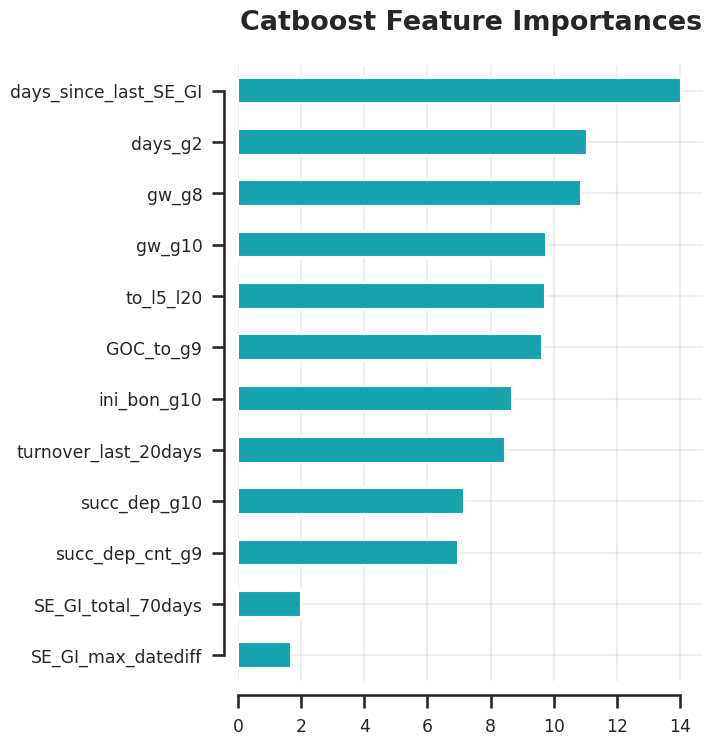

In [10]:
# Show feature importances
feature_names = [feat.split('__')[1] for feat in model_pipeline['clf'].feature_names_]
feat_importances = pd.Series(
    model_pipeline['clf'].feature_importances_,
    index=feature_names
).sort_values()

feat_importances.plot.barh(figsize=(6,8))
plt.yticks(size='small')
plt.xticks(size='small')
sns.despine(trim=True, offset=10)
plt.title('Catboost Feature Importances', size='x-large', y=.99)
plt.show()

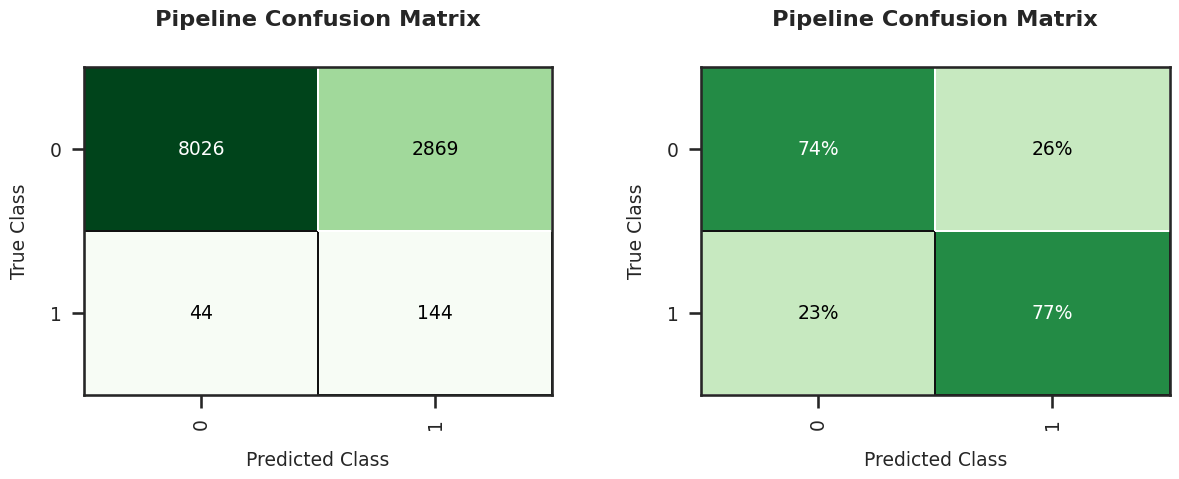

In [11]:
# Confusion_matrix
fig, axes = plt.subplots(ncols=2, figsize=(12,5))

confusion_matrix(wrap(model_pipeline), X_test, y_test, cmap='Greens', percent=False, ax=axes[0], show=False)
confusion_matrix(wrap(model_pipeline), X_test, y_test, cmap='Greens', percent=True, ax=axes[1], show=False)

plt.tight_layout(w_pad=4)

plt.show()

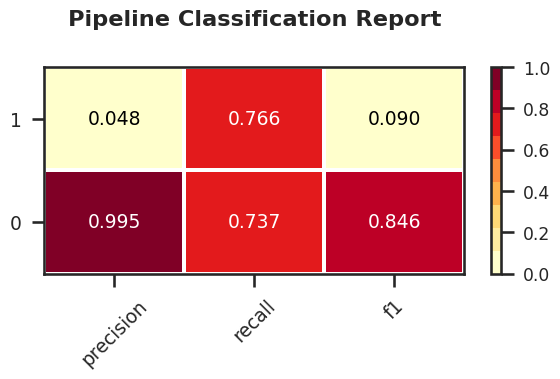

In [12]:
# Classification report
classification_report(wrap(model_pipeline), X_test, y_test);

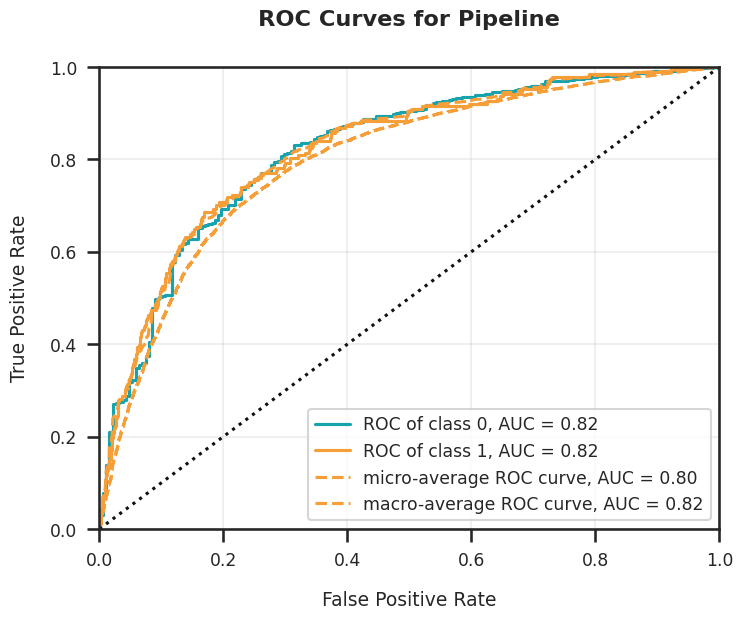

In [13]:
# ROC-AUC curve
plt.figure(figsize=(8,6))
roc_auc(wrap(model_pipeline), X_train, y_train, X_test=X_test, y_test=y_test);

## Interpret model

In [14]:
# Extrac fitted preprocessor and model
fitted_preprocessor = model_pipeline['preprocessor']
fitted_model = model_pipeline['clf']

# Extract transformed data
X_train_transformed = fitted_preprocessor.transform(X_train)
X_test_transformed = fitted_preprocessor.transform(X_test)

# Sample for showing on shap plots
X_train_transformed_100 = shap.utils.sample(X_train_transformed, 100)

# Select feature names
feature_names = [col.split('__')[1] for col in X_train_transformed.columns]

In [15]:
# compute SHAP values
explainer = shap.Explainer(fitted_model, feature_names=feature_names)
shap_values = explainer(X_train_transformed)

In [16]:
# Function to fix remove prefix from the shap plots
def update_yticklabels(ax):
    y_tick_labels = [label.get_text().replace('selected_features__', '') for label in ax.get_yticklabels()]
    ax.set_yticklabels(y_tick_labels)

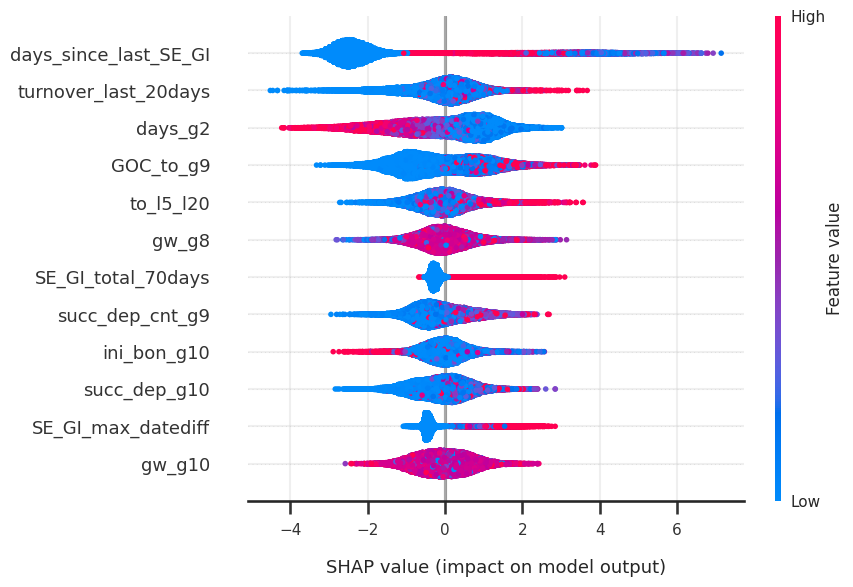

In [17]:
# Beeswarm summary plot
ax = shap.plots.beeswarm(shap_values, order=shap_values.abs.max(0), max_display=12, show=False)
update_yticklabels(plt.gca())
plt.show()

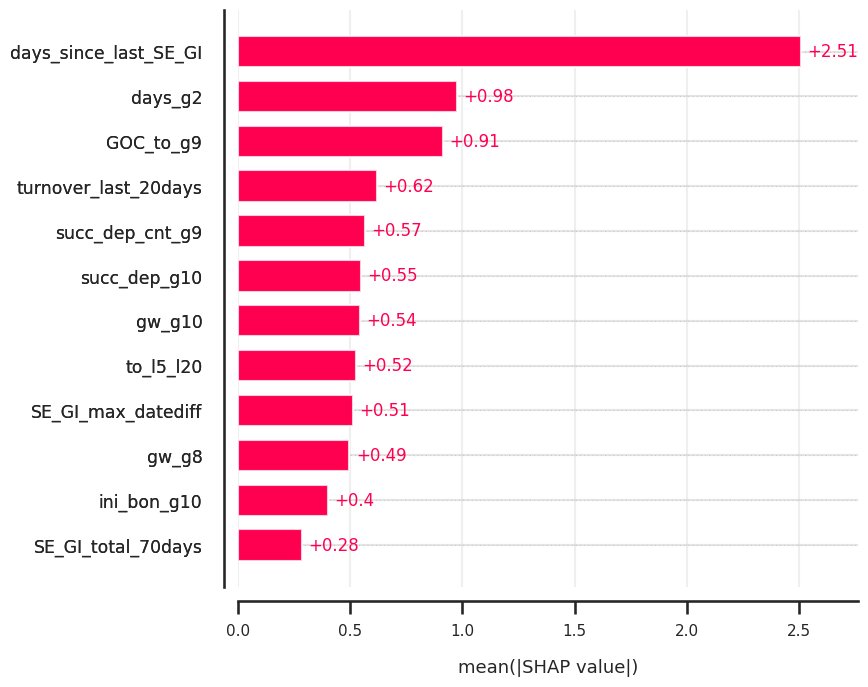

In [18]:
shap.plots.bar(shap_values, max_display=12, show=False)
update_yticklabels(plt.gca())
sns.despine(offset=10)
plt.show()

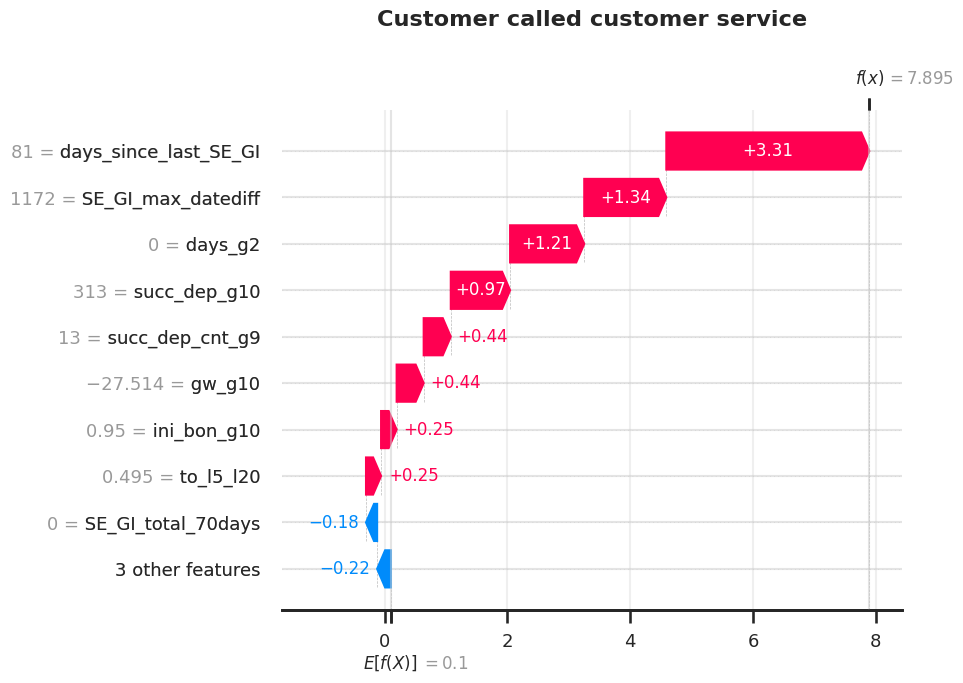

In [19]:
# Show an example of a positive target instance
positive_target_idx = np.where(y_train==1)[0]

ax = shap.plots.waterfall(shap_values[positive_target_idx[1]], max_display=10, show=False)
ax.set_title('Customer called customer service')
update_yticklabels(plt.gca())
plt.show()

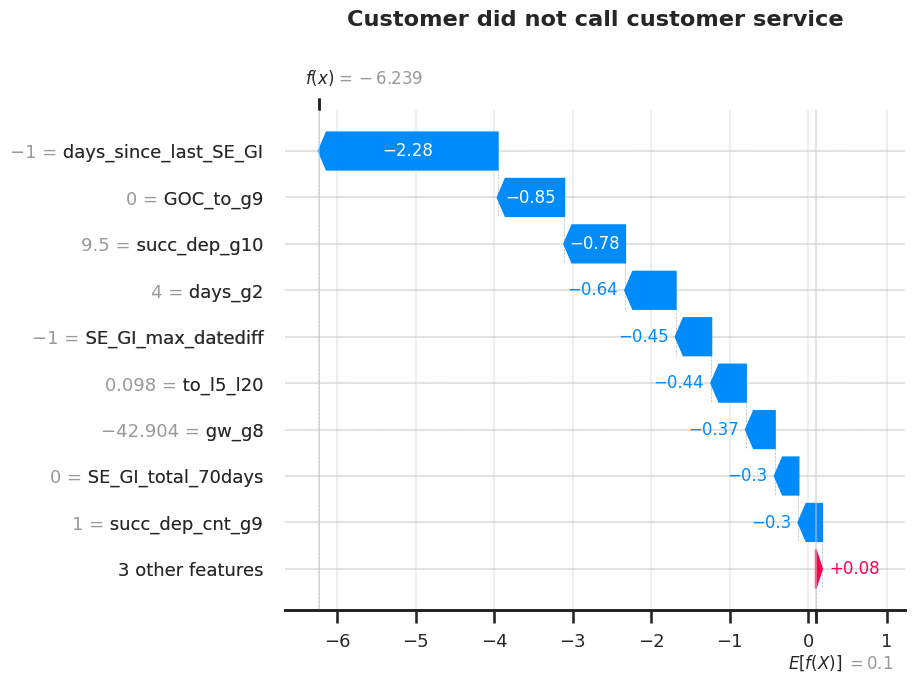

In [20]:
# Show an example of a negative target instance
negative_target_idx = np.where(y_train==0)[0]

ax = shap.plots.waterfall(shap_values[negative_target_idx[2]], max_display=10, show=False)
ax.set_title('Customer did not call customer service')
update_yticklabels(plt.gca())
plt.show()

## Finalize model

I'm train the model once again with the whole train set, and then apply it in the test set (with no labels):

In [21]:
# Finalize model (train with full train data)
final_model = model_pipeline.fit(X, y)

In [ ]:
# Predict test data (challenge)
df_predictions = pd.DataFrame({
    'mk_CurrentCustomer': df_test.index,
    'Prediction': final_model.predict(df_test)
    }
)

df_predictions.to_csv('predictions/test_predictions.csv', index=False)

In [ ]:
# Save model
with open('models/model.pkl', 'wb') as model_file:
    pickle.dump(final_model, model_file)